## This notebook runs inference on a GEARS model trained on Norman

- Download trained GEARS model and Dataloader from Dataverse
- Model is trained on Norman et al. 2019 (Science) dataset
- Example below showing how to make perturbation outcome prediction and GI prediction

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Programmable Biology Group/Srikar/tf-flow-design/gears/')

In [4]:
# !git clone https://github.com/snap-stanford/GEARS

In [5]:
!ls

all_final_states.npy		   norman_single_gene_subset_7.h5ad
all_initial_states.npy		   norman_single_gene_subset_8.h5ad
all_metrics.npy			   norman_single_gene_subset_9.h5ad
all_transition_states.npy	   norman_single_gene_subset.h5ad
essential_all_data_pert_genes.pkl  norman_umi_go
GEARS				   norman_umi_go.tar.gz
gears_test_notebook.ipynb	   pooled_expression_subset_0.npy
gene2go_all.pkl			   pooled_expression_subset_10.npy
ground_truths.npy		   pooled_expression_subset_11.npy
model_ckpt			   pooled_expression_subset_12.npy
model.zip			   pooled_expression_subset_13.npy
norman_single_gene.h5ad		   pooled_expression_subset_14.npy
norman_single_gene_subset_0.h5ad   pooled_expression_subset_15.npy
norman_single_gene_subset_10.h5ad  pooled_expression_subset_16.npy
norman_single_gene_subset_11.h5ad  pooled_expression_subset_17.npy
norman_single_gene_subset_12.h5ad  pooled_expression_subset_18.npy
norman_single_gene_subset_13.h5ad  pooled_expression_subset_1.npy
norman_single_gene_subset_14.h

In [6]:
!pip install numpy pandas tqdm scikit-learn torch torch_geometric scanpy networkx dcor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=b03e6a69a641a332a181c04cd12c133e5f8cd3361d3a67e155609e302b7a942b
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [7]:
!ls '/content/drive/MyDrive/Programmable Biology Group/Srikar/tf-flow-design/gears/'

all_final_states.npy		   norman_single_gene_subset_7.h5ad
all_initial_states.npy		   norman_single_gene_subset_8.h5ad
all_metrics.npy			   norman_single_gene_subset_9.h5ad
all_transition_states.npy	   norman_single_gene_subset.h5ad
essential_all_data_pert_genes.pkl  norman_umi_go
GEARS				   norman_umi_go.tar.gz
gears_test_notebook.ipynb	   pooled_expression_subset_0.npy
gene2go_all.pkl			   pooled_expression_subset_10.npy
ground_truths.npy		   pooled_expression_subset_11.npy
model_ckpt			   pooled_expression_subset_12.npy
model.zip			   pooled_expression_subset_13.npy
norman_single_gene.h5ad		   pooled_expression_subset_14.npy
norman_single_gene_subset_0.h5ad   pooled_expression_subset_15.npy
norman_single_gene_subset_10.h5ad  pooled_expression_subset_16.npy
norman_single_gene_subset_11.h5ad  pooled_expression_subset_17.npy
norman_single_gene_subset_12.h5ad  pooled_expression_subset_18.npy
norman_single_gene_subset_13.h5ad  pooled_expression_subset_1.npy
norman_single_gene_subset_14.h

In [8]:
os.chdir('/content/drive/MyDrive/Programmable Biology Group/Srikar/tf-flow-design/gears/')

In [9]:
import sys
sys.path.append('.')
from GEARS.gears import PertData, GEARS
from GEARS.gears.utils import dataverse_download
from zipfile import ZipFile

### Download saved model and dataloader

In [10]:
## Download dataloader from dataverse
dataverse_download('https://dataverse.harvard.edu/api/access/datafile/6979957', 'norman_umi_go.tar.gz')

## Extract and set up dataloader directory
import tarfile
with tarfile.open('norman_umi_go.tar.gz', 'r:gz') as tar:
    tar.extractall()

Found local copy...


In [11]:
## Download model from dataverse
dataverse_download('https://dataverse.harvard.edu/api/access/datafile/10457098', 'model.zip')

## Extract and set up model directory
with ZipFile(('model.zip'), 'r') as zip:
    zip.extractall(path = './')

Found local copy...


### Load model and dataloader

In [12]:
data_path = './'
data_name = 'norman_umi_go'
model_name = 'gears_misc_umi_no_test'

pert_data = PertData(data_path)
pert_data.load(data_path = data_path + data_name)
pert_data.prepare_split(split = 'no_test', seed = 1)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

gears_model = GEARS(pert_data, device = 'cuda:0',
                        weight_bias_track = False,
                        proj_name = 'gears',
                        exp_name = model_name)
gears_model.load_pretrained('./model_ckpt')

Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...


here1


Done!
Creating dataloaders....
Done!


In [13]:
gears_model = GEARS(pert_data, device = 'cuda:0',
                        weight_bias_track = False,
                        proj_name = 'gears',
                        exp_name = model_name)
gears_model.load_pretrained('./model_ckpt')

### Make transcriptional outcome predictions

In [14]:
pert_data

In [15]:
# create a gene list
import scanpy as sc
norman_data = sc.read_h5ad('/content/drive/MyDrive/Programmable Biology Group/Srikar/tf-flow-design/gears/norman_umi_go/perturb_processed.h5ad')

In [16]:
norman_data.obs

,condition,cell_type,dose_val,control,condition_name
cell_barcode,,,,,
AAACCTGAGGCATGTG-1,TSC22D1+ctrl,K562,1+1,0,K562_TSC22D1+ctrl_1+1
AAACCTGAGGCCCTTG-1,KLF1+MAP2K6,K562,1+1,0,K562_KLF1+MAP2K6_1+1
AAACCTGCACGAAGCA-1,ctrl,K562,1,1,K562_ctrl_1
AAACCTGCAGACGTAG-1,CEBPE+RUNX1T1,K562,1+1,0,K562_CEBPE+RUNX1T1_1+1
AAACCTGCAGCCTTGG-1,MAML2+ctrl,K562,1+1,0,K562_MAML2+ctrl_1+1
...,...,...,...,...,...
TTTGTCAGTCATGCAT-8,RHOXF2BB+SET,K562,1+1,0,K562_RHOXF2BB+SET_1+1
TTTGTCATCAGTACGT-8,FOXA3+ctrl,K562,1+1,0,K562_FOXA3+ctrl_1+1
TTTGTCATCCACTCCA-8,CELF2+ctrl,K562,1+1,0,K562_CELF2+ctrl_1+1


In [17]:
def extract_gene(condition):
    genes = [part for part in condition.split('+') if part != 'ctrl']
    return genes[0] if len(genes) == 1 else None

norman_data.obs['single_gene'] = norman_data.obs['condition'].apply(extract_gene)
single_gene_data = norman_data[norman_data.obs['single_gene'].notnull()].copy()


In [18]:
single_gene_data.obs['single_gene'].unique()

array(['TSC22D1', 'MAML2', 'CEBPE', 'DUSP9', 'ELMSAN1', 'FOXA1', 'BCORL1',
       'MEIS1', 'GLB1L2', 'KLF1', 'BAK1', 'FEV', 'CBL', 'ETS2', 'SET',
       'TBX3', 'LHX1', 'SLC4A1', 'RREB1', 'ZNF318', 'COL2A1', 'ZBTB25',
       'MAP4K5', 'UBASH3B', 'SLC6A9', 'MIDN', 'DLX2', 'CBFA2T3', 'HES7',
       'AHR', 'FOXO4', 'RHOXF2BB', 'RUNX1T1', 'S1PR2', 'POU3F2', 'CNN1',
       'CELF2', 'MAP2K3', 'MAP4K3', 'CDKN1A', 'PTPN1', 'TBX2', 'IER5L',
       'PTPN12', 'TP73', 'MAP7D1', 'FOSB', 'MAPK1', 'C19orf26', 'IRF1',
       'IKZF3', 'HOXB9', 'HOXC13', 'CKS1B', 'CLDN6', 'FOXA3', 'SAMD1',
       'COL1A1', 'FOXF1', 'ZBTB1', 'PRTG', 'PLK4', 'BPGM', 'ARRDC3',
       'C3orf72', 'LYL1', 'MAP2K6', 'SGK1', 'FOXL2', 'KIAA1804', 'CEBPA',
       'HNF4A', 'KMT2A', 'IGDCC3', 'ISL2', 'TMSB4X', 'KIF2C', 'CSRNP1',
       'ARID1A', 'CNNM4', 'UBASH3A', 'NCL', 'BCL2L11', 'ZC3HAV1', 'OSR2',
       'SPI1', 'STIL', 'CEBPB', 'ATL1', 'NIT1', 'CDKN1B', 'TGFBR2', 'JUN',
       'ZBTB10', 'PTPN13', 'SLC38A2', 'PTPN9', 'SNAI1', '

In [19]:
single_gene_data.obs['single_gene']

,single_gene
cell_barcode,
AAACCTGAGGCATGTG-1,TSC22D1
AAACCTGCAGCCTTGG-1,MAML2
AAACCTGCATCTCCCA-1,CEBPE
AAACCTGGTCTGATTG-1,DUSP9
AAACCTGGTTTCCACC-1,ELMSAN1
...,...
TTTGTCAGTAGGCATG-8,COL2A1
TTTGTCATCAGTACGT-8,FOXA3
TTTGTCATCCACTCCA-8,CELF2


In [20]:
single_gene_data.obs

,condition,cell_type,dose_val,control,condition_name,single_gene
cell_barcode,,,,,,
AAACCTGAGGCATGTG-1,TSC22D1+ctrl,K562,1+1,0,K562_TSC22D1+ctrl_1+1,TSC22D1
AAACCTGCAGCCTTGG-1,MAML2+ctrl,K562,1+1,0,K562_MAML2+ctrl_1+1,MAML2
AAACCTGCATCTCCCA-1,ctrl+CEBPE,K562,1+1,0,K562_ctrl+CEBPE_1+1,CEBPE
AAACCTGGTCTGATTG-1,DUSP9+ctrl,K562,1+1,0,K562_DUSP9+ctrl_1+1,DUSP9
AAACCTGGTTTCCACC-1,ctrl+ELMSAN1,K562,1+1,0,K562_ctrl+ELMSAN1_1+1,ELMSAN1
...,...,...,...,...,...,...
TTTGTCAGTAGGCATG-8,COL2A1+ctrl,K562,1+1,0,K562_COL2A1+ctrl_1+1,COL2A1
TTTGTCATCAGTACGT-8,FOXA3+ctrl,K562,1+1,0,K562_FOXA3+ctrl_1+1,FOXA3
TTTGTCATCCACTCCA-8,CELF2+ctrl,K562,1+1,0,K562_CELF2+ctrl_1+1,CELF2


In [21]:
single_gene_data.write('norman_single_gene.h5ad')

In [22]:
import pandas as pd

condition_column = norman_data.obs['condition']
def extract_gene(condition):
    genes = [part for part in condition.split('+') if part != 'ctrl']
    return genes[0] if genes else None


In [23]:
genes_norman = condition_column.apply(extract_gene)
unique_genes = genes_norman.unique()
unique_genes = genes_norman[genes_norman != "None"].unique()

In [24]:
norman_genes = unique_genes

In [25]:
!ls '/content/drive/MyDrive/Programmable Biology Group/Srikar/tf-flow-design/gonadal/data/cosg_csvs/'

cosg_dpt_ipsc_oocyte_combined_ranked_genes.csv
cosg_dpt_ipsc_oogonia_meiotic_combined_ranked_genes.csv
cosg_dpt_ipsc_oogonia_STRA8_combined_ranked_genes.csv
cosg_dpt_ipsc_PGC_combined_ranked_genes.csv
cosg_dpt_ipsc_pre_oocyte_combined_ranked_genes.csv
cosg_dpt_oocyte_oogonia_meiotic_combined_ranked_genes.csv
cosg_dpt_oocyte_pre_oocyte_combined_ranked_genes.csv
cosg_dpt_oogonia_STRA8_oocyte_combined_ranked_genes.csv
cosg_dpt_oogonia_STRA8_oogonia_meiotic_combined_ranked_genes.csv
cosg_dpt_oogonia_STRA8_pre_oocyte_combined_ranked_genes.csv
cosg_dpt_PGC_oocyte_combined_ranked_genes.csv
cosg_dpt_PGC_oogonia_meiotic_combined_ranked_genes.csv
cosg_dpt_PGC_oogonia_STRA8_combined_ranked_genes.csv
cosg_dpt_PGC_pre_oocyte_combined_ranked_genes.csv
cosg_dpt_pre_oocyte_oogonia_meiotic_combined_ranked_genes.csv


In [26]:
import os
import pandas as pd

csv_folder = '/content/drive/MyDrive/Programmable Biology Group/Srikar/tf-flow-design/gonadal/data/cosg_csvs/'
csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]
unique_genes_set = set()

for csv_file in csv_files:
    file_path = os.path.join(csv_folder, csv_file)
    df = pd.read_csv(file_path)
    second_column = df.iloc[:, 1]
    top_20_genes = second_column.head(20)
    unique_genes_set.update(top_20_genes)
unique_genes_list = sorted(list(unique_genes_set))


In [27]:
cosg_genes = set(unique_genes_list)

In [28]:
gonadal_gt_genes = set([
    "POU5F1", "SOX2", "PRDM1", "TFAP2A", "ZFP42", "NANOG", "KLF4", "PRRX1", "SP5", "PRDM14",
    "LHX1", "UTF1", "TBX3", "TFCP2L1", "SOX17", "NANOS3", "STELLA", "TCFAP2C", "LIN28A",
    "BLIMP1", "DNMT3L", "ZSCAN4", "EBF3", "DNMT3B", "ZIC3", "ZIC5", "SOX4", "JUND",
    "NPM2", "UHRF1", "SOX9", "DMRT1", "FOXL2", "NANOS2", "ETV5", "HSPB1", "FOXC2", "LHX1",
    "HOXA3", "HOXA5", "HOXA1", "HOXB1", "LHX8", "SOHLH1", "CDH5", "SOHLH2", "SPO11",
    "RNF17", "RAD51", "HDAC1", "NMT1", "PMF1", "NME5", "HDAC3", "WST1", "CDX2", "HOXA4",
    "FOXP1", "FOXP2", "DNMT3A", "NEUROD3", "KLF2", "SOX12", "FOXO3", "YBX2", "PINK1", "BCL6"
])

In [29]:
print(len(cosg_genes), len(gonadal_gt_genes), len(norman_genes))
unique_genes = set(cosg_genes) | set(gonadal_gt_genes) | set(norman_genes)
print(len(unique_genes))

146 66 106
311


In [ ]:
unique_genes = list(unique_genes)
# Save the list of unique genes
with open('unique_genes.txt', 'w') as f:
    for gene in unique_genes:
        f.write(f"{gene}\n")

In [ ]:
print(len(gears_model.pert_list))
filtered_genes = [gene for gene in unique_genes if gene in gears_model.pert_list]

9853


In [ ]:
len(filtered_genes)

224

In [ ]:
len(cosg_genes)
cosg_genes_filtered = [gene for gene in cosg_genes if gene in gears_model.pert_list]

In [1]:
genes_pert_list = list(gears_model.pert_list)
len(genes_pert_list)

NameError: name 'gears_model' is not defined

In [ ]:
genes_pert_list = list(gears_model.pert_list)
predictions = {}

for gene in genes_pert_list:
    predictions[gene] = gears_model.predict([[gene]])[gene]

# Save the predictions as a NumPy array
import numpy as np
np.save('predictions_pertlist.npy', predictions)


In [ ]:
gears_model.predict([['CNN1']])

{'CNN1': array([1.1007402e-03, 4.1889349e-01, 3.3616759e-02, ..., 3.6995113e+00,
        5.4664047e-09, 4.2321062e-01], dtype=float32)}

In [ ]:
len(predictions)

224

## filtered genes gears analysis

In [ ]:
single_gene_data

In [ ]:
import numpy as np

n_cells_per_gene = 3
unique_genes = single_gene_data.obs['single_gene'].unique()

max_subsets = float('inf')

for gene in unique_genes:
    gene_cells = single_gene_data.obs[single_gene_data.obs['single_gene'] == gene].index
    n_cells_available = len(gene_cells)
    n_groups = n_cells_available // n_cells_per_gene

    if n_groups < max_subsets:
        max_subsets = n_groups

print(f"Maximum number of subsets possible: {max_subsets}")


Maximum number of subsets possible: 32


In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd

def create_balanced_subsets(single_gene_data, cells_per_gene=5, max_subsets=None):
    unique_genes = single_gene_data.obs['single_gene'].unique()
    all_subsets = []
    remaining_data = single_gene_data.copy()

    while True:
        selected_cells = pd.Series(False, index=remaining_data.obs_names)
        for gene in unique_genes:
            gene_mask = remaining_data.obs['single_gene'] == gene
            gene_cells = remaining_data.obs_names[gene_mask]
            n_cells_available = len(gene_cells)

            if n_cells_available >= cells_per_gene:
                sampled_cells = np.random.choice(gene_cells, size=cells_per_gene, replace=False)
                selected_cells.loc[sampled_cells] = True
            else:
                break  # Not enough cells left for this gene, stop creating subsets

        if selected_cells.sum() == len(unique_genes) * cells_per_gene:
            subset_data = remaining_data[selected_cells].copy()
            all_subsets.append(subset_data)
            remaining_data = remaining_data[~selected_cells].copy()

            if max_subsets and len(all_subsets) >= max_subsets:
                break
        else:
            break  # Couldn't create a full subset, stop the process

    return all_subsets

In [ ]:
subsets = create_balanced_subsets(single_gene_data, cells_per_gene=5, max_subsets=None)

In [ ]:

for i, subset in enumerate(subsets):
    subset.write(f'norman_single_gene_subset_{i}.h5ad')

print(f"Created {len(subsets)} balanced subsets.")

Created 19 balanced subsets.


In [ ]:
subsets[0].X

<525x5054 sparse matrix of type '<class 'numpy.float32'>'
	with 1007178 stored elements in Compressed Sparse Row format>

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
dense_matrix = subsets[0].X.toarray()
print(dense_matrix.shape)
pooled_expression = np.mean(dense_matrix, axis=0)
pooled_expression_sparse = csr_matrix(pooled_expression).T
print(pooled_expression.shape)
print(pooled_expression_sparse.shape)

(525, 5054)
(5054,)
(5054, 1)


In [ ]:
pooled_expression

array([0.        , 0.37042326, 0.01397497, ..., 3.6979895 , 0.        ,
       0.4195442 ], dtype=float32)

In [ ]:
subsets[0].var

,gene_name
gene_id,
ENSG00000239945,RP11-34P13.8
ENSG00000279457,FO538757.2
ENSG00000187634,SAMD11
ENSG00000188976,NOC2L
ENSG00000187608,ISG15
...,...
ENSG00000198786,MT-ND5
ENSG00000198695,MT-ND6
ENSG00000198727,MT-CYB


In [ ]:
filtered_genes[0]

'SOHLH2'

In [ ]:
print(len(predictions))
len(predictions['SOHLH2'])

224


5054

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
import scanpy as sc

def calculate_pooled_expression(subset):
    dense_matrix = subset.X.toarray()
    pooled_expression = np.mean(dense_matrix, axis=0)
    return pooled_expression

ground_truths = []

for i, subset in enumerate(subsets):
    pooled_expression = calculate_pooled_expression(subset)
    ground_truths.append(pooled_expression)
    print(f"Subset {i}:")
    print(f"  Original shape: {subset.X.shape}")
    print(f"  Pooled expression shape: {pooled_expression.shape}")

    # save each subset's pooled expression separately first
    np.save(f'pooled_expression_subset_{i}.npy', pooled_expression)

ground_truths_array = np.array(ground_truths)

np.save('ground_truths.npy', ground_truths_array)

print(f"\nSaved ground truths for {len(subsets)} subsets.")
print(f"Ground truths array shape: {ground_truths_array.shape}")

Subset 0:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 1:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 2:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 3:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 4:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 5:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 6:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 7:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 8:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 9:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 10:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 11:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 12:
  Original shape: (525, 5054)
  Pooled expression shape: (5054,)
Subset 13:
  Original 

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

def calculate_metrics(ground_truth, prediction, initial_state, transition_state):
    ground_truth = ground_truth.flatten()
    prediction = prediction.flatten()
    initial_state = initial_state.flatten()
    transition_state = transition_state.flatten()

    mse_final = mean_squared_error(ground_truth, ground_truth + prediction)
    mse_initial = mean_squared_error(ground_truth, initial_state)
    mse_transition = mean_squared_error(ground_truth, transition_state)

    cos_sim_final = cosine_similarity(ground_truth.reshape(1, -1),
                                      (ground_truth + prediction).reshape(1, -1))[0][0]
    cos_sim_initial = cosine_similarity(ground_truth.reshape(1, -1),
                                        initial_state.reshape(1, -1))[0][0]
    cos_sim_transition = cosine_similarity(ground_truth.reshape(1, -1),
                                           transition_state.reshape(1, -1))[0][0]

    cos_dist_final = cosine(ground_truth, ground_truth + prediction)
    cos_dist_initial = cosine(ground_truth, initial_state)
    cos_dist_transition = cosine(ground_truth, transition_state)

    return {
        'mse_final': mse_final,
        'mse_initial': mse_initial,
        'mse_transition': mse_transition,
        'cosine_similarity_final': cos_sim_final,
        'cosine_similarity_initial': cos_sim_initial,
        'cosine_similarity_transition': cos_sim_transition,
        'cosine_distance_final': cos_dist_final,
        'cosine_distance_initial': cos_dist_initial,
        'cosine_distance_transition': cos_dist_transition
    }

ground_truths = np.load('ground_truths.npy')
predictions = np.load('predictions.npy', allow_pickle=True).item()  # Load as dictionary

print(f"Ground truths shape: {ground_truths.shape}")
print(f"Number of genes in predictions: {len(predictions)}")

all_metrics = {}
all_final_states = {}
all_initial_states = {}
all_transition_states = {}

for gene, pred_array in predictions.items():
    gene_metrics = []
    gene_final_states = []
    gene_initial_states = []
    gene_transition_states = []

    for gt in ground_truths:
        initial_state = gt - pred_array
        final_state = gt + pred_array
        transition_state = pred_array  # The transition state is the prediction itself
        metrics = calculate_metrics(gt, pred_array, initial_state, transition_state)
        gene_metrics.append(metrics)
        gene_final_states.append(final_state)
        gene_initial_states.append(initial_state)
        gene_transition_states.append(transition_state)

    all_metrics[gene] = gene_metrics
    all_final_states[gene] = gene_final_states
    all_initial_states[gene] = gene_initial_states
    all_transition_states[gene] = gene_transition_states

np.save('all_final_states.npy', all_final_states)
np.save('all_initial_states.npy', all_initial_states)
np.save('all_transition_states.npy', all_transition_states)
np.save('all_metrics.npy', all_metrics)

print(f"\nProcessed {len(ground_truths)} ground truths for {len(predictions)} genes")
print(f"Total comparisons: {len(ground_truths) * len(predictions)}")

# Calculate average metrics across all genes and ground truths
avg_metrics = {
    'mse_final': np.mean([m['mse_final'] for gene_metrics in all_metrics.values() for m in gene_metrics]),
    'mse_initial': np.mean([m['mse_initial'] for gene_metrics in all_metrics.values() for m in gene_metrics]),
    'mse_transition': np.mean([m['mse_transition'] for gene_metrics in all_metrics.values() for m in gene_metrics]),
    'cosine_similarity_final': np.mean([m['cosine_similarity_final'] for gene_metrics in all_metrics.values() for m in gene_metrics]),
    'cosine_similarity_initial': np.mean([m['cosine_similarity_initial'] for gene_metrics in all_metrics.values() for m in gene_metrics]),
    'cosine_similarity_transition': np.mean([m['cosine_similarity_transition'] for gene_metrics in all_metrics.values() for m in gene_metrics])
}

for metric, value in avg_metrics.items():
    print(f"Average {metric}: {value}")

print("\nSaved all_final_states.npy, all_initial_states.npy, all_transition_states.npy, and all_metrics.npy")

Ground truths shape: (19, 5054)
Number of genes in predictions: 224

Processed 19 ground truths for 224 genes
Total comparisons: 4256
Average mse_final: 0.7832462787628174
Average mse_initial: 0.7832462787628174
Average mse_transition: 0.002380837220698595
Average cosine_similarity_final: 0.9996457099914551
Average cosine_similarity_initial: -0.19452638924121857
Average cosine_similarity_transition: 0.9985834360122681

Saved all_final_states.npy, all_initial_states.npy, all_transition_states.npy, and all_metrics.npy


## all pert_list gears analysis

In [4]:
!ls

essential_all_data_pert_genes.pkl  gene2go_all.pkl  norman_umi_go.tar.gz
fg_244_results			   model_ckpt	    predictions_pertlist.npy
GEARS				   model.zip	    subset_norman_expression
gears_test_notebook.ipynb	   norman_umi_go    subset_pooled_expression


In [25]:
import numpy as np
predictions_pertlist = np.load('predictions_pertlist.npy',allow_pickle=True)

In [27]:
predictions_pertlist.item()['C6orf15']

array([5.9619424e-04, 3.5445735e-01, 2.3206444e-02, ..., 3.6983988e+00,
       3.9944018e-10, 3.7022388e-01], dtype=float32)

In [28]:
import pandas as pd
df = pd.DataFrame.from_dict(predictions_pertlist.item(), orient='index')

In [30]:
df.T.to_csv('predictions_pertlist.csv')
df = df.T

In [32]:
!pip install scanpy
import scanpy as sc
norman = sc.read_h5ad('norman_umi_go/perturb_processed.h5ad')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=3e5996fb1de91b796e85eaf7ca7f9379501750bc9a4042d54e44f3d84ee6c486
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [36]:
norman_genes = list(norman.var['gene_name'])

In [39]:
df.index = norman_genes
df.to_csv('predictions_pertlist.csv')

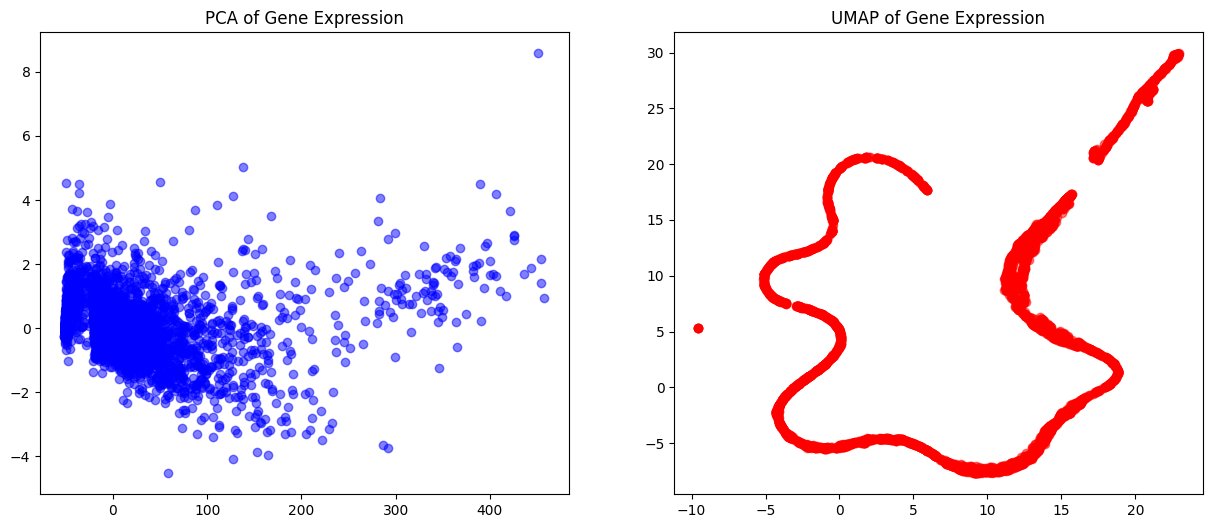

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.values)
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c='blue', alpha=0.5)
axes[0].set_title('PCA of Gene Expression')

# UMAP
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(df.values)
axes[1].scatter(umap_result[:, 0], umap_result[:, 1], c='red', alpha=0.5)
axes[1].set_title('UMAP of Gene Expression')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


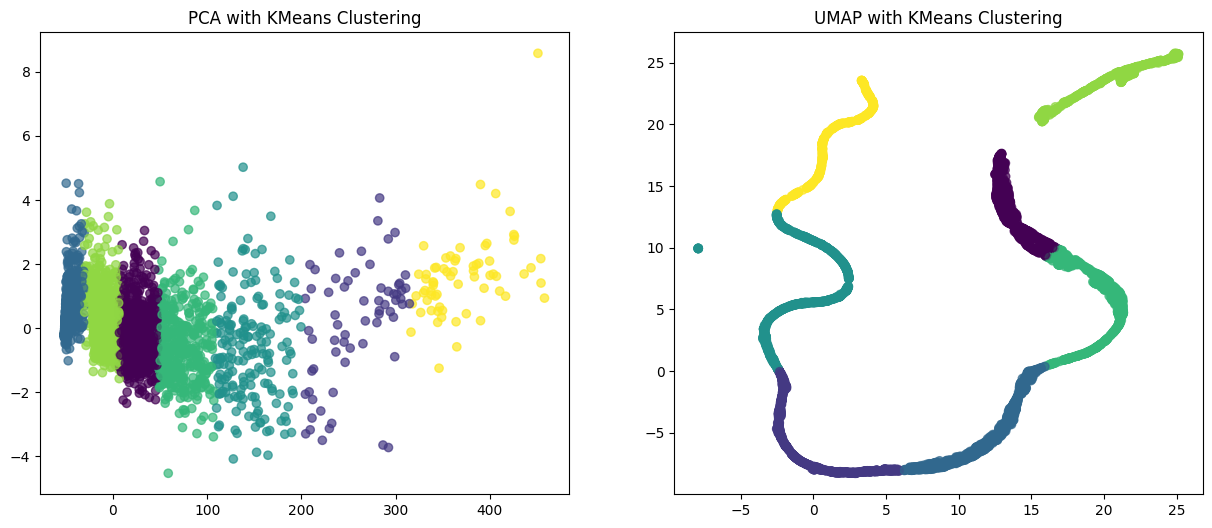

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.values)

kmeans_pca = KMeans(n_clusters=7)
clusters_pca = kmeans_pca.fit_predict(pca_result)

axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=clusters_pca, cmap='viridis', alpha=0.7)
axes[0].set_title('PCA with KMeans Clustering')

# UMAP
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(df.values)

kmeans_umap = KMeans(n_clusters=7)
clusters_umap = kmeans_umap.fit_predict(umap_result)

axes[1].scatter(umap_result[:, 0], umap_result[:, 1], c=clusters_umap, cmap='viridis', alpha=0.7)
axes[1].set_title('UMAP with KMeans Clustering')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

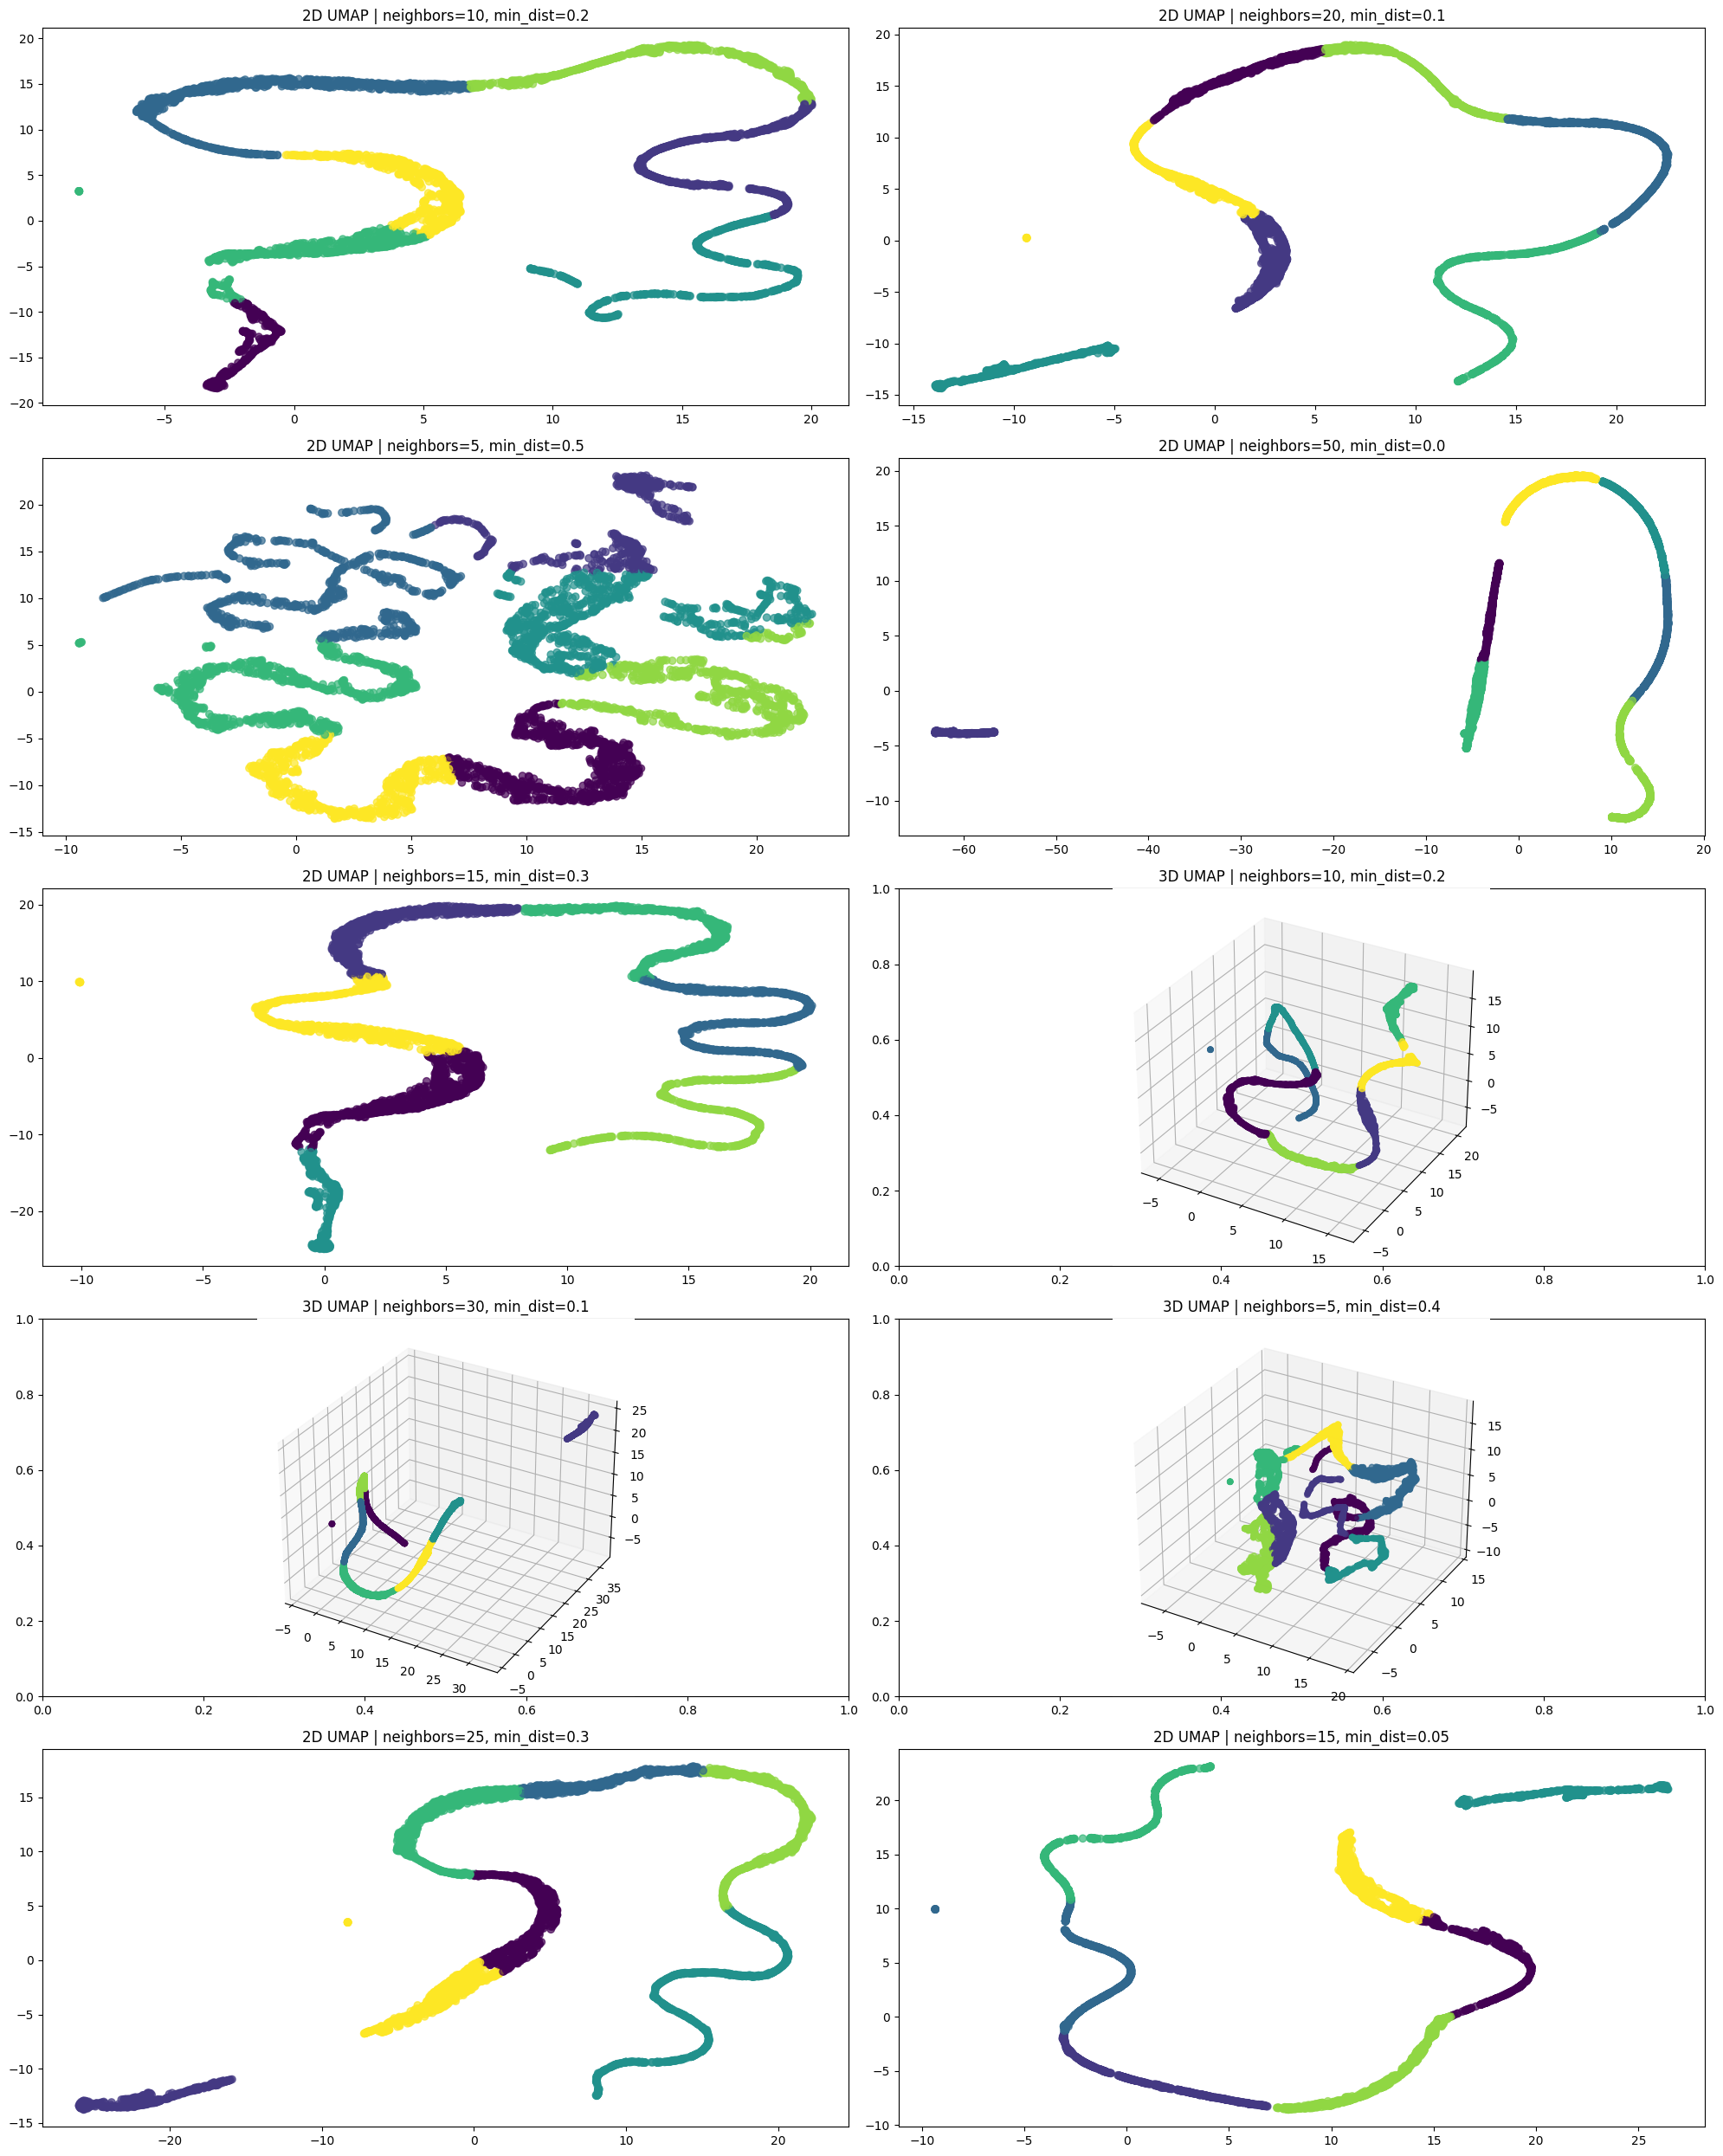

In [42]:
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import KMeans

fig, axes = plt.subplots(5, 2, figsize=(20, 25))

# UMAP Variations
umap_variations = [
    {'n_components': 2, 'n_neighbors': 10, 'min_dist': 0.2},
    {'n_components': 2, 'n_neighbors': 20, 'min_dist': 0.1},
    {'n_components': 2, 'n_neighbors': 5, 'min_dist': 0.5},
    {'n_components': 2, 'n_neighbors': 50, 'min_dist': 0.0},
    {'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.3},
    {'n_components': 3, 'n_neighbors': 10, 'min_dist': 0.2},
    {'n_components': 3, 'n_neighbors': 30, 'min_dist': 0.1},
    {'n_components': 3, 'n_neighbors': 5, 'min_dist': 0.4},
    {'n_components': 2, 'n_neighbors': 25, 'min_dist': 0.3},
    {'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.05}
]

# Plot each variation
for i, params in enumerate(umap_variations):
    umap = UMAP(n_components=params['n_components'], n_neighbors=params['n_neighbors'], min_dist=params['min_dist'])
    umap_result = umap.fit_transform(df.values)

    kmeans = KMeans(n_clusters=7)
    clusters = kmeans.fit_predict(umap_result)

    ax = axes[i // 2, i % 2]

    if params['n_components'] == 2:
        ax.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        ax.set_title(f"2D UMAP | neighbors={params['n_neighbors']}, min_dist={params['min_dist']}")
    else:
        ax = fig.add_subplot(5, 2, i+1, projection='3d')
        ax.scatter(umap_result[:, 0], umap_result[:, 1], umap_result[:, 2], c=clusters, cmap='viridis', alpha=0.7)
        ax.set_title(f"3D UMAP | neighbors={params['n_neighbors']}, min_dist={params['min_dist']}")

plt.tight_layout()
plt.show()


In [44]:
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
!pip install leidenalg
import leidenalg as la
!pip install igraph
import igraph as ig


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 101.3 MB/s eta 0:00:00


In [50]:
df = df.T
df

,RP11-34P13.8,FO538757.2,SAMD11,NOC2L,ISG15,RP11-54O7.18,RNF223,SDF4,UBE2J2,TAS1R3,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC023491.2,AC004556.1
A1BG,0.000885,0.349475,0.026148,0.626933,0.350203,-1.224962e-34,0.081381,0.540667,0.562544,0.000329,...,4.054720,5.105600,3.522295,1.233377,4.463252,2.097919,1.484621,3.705872,1.059164e-09,0.409891
AAAS,0.001018,0.384084,0.035657,0.615849,0.399781,-1.131093e-34,0.084713,0.485105,0.578529,0.000340,...,4.026491,5.085740,3.500338,1.215845,4.451210,2.120566,1.537431,3.682621,1.188340e-09,0.436428
AACS,0.000918,0.377180,0.032573,0.552642,0.416802,-1.123511e-34,0.082567,0.523191,0.594450,0.000329,...,4.046396,5.108284,3.524832,1.199657,4.452176,2.113066,1.494010,3.694978,1.076899e-09,0.392249
AAGAB,0.000902,0.383629,0.029155,0.598333,0.335640,-1.155060e-34,0.081315,0.482669,0.564902,0.000328,...,4.076481,5.111618,3.506962,1.196412,4.474549,2.132464,1.530857,3.709644,1.036103e-09,0.396281
AAK1,0.001292,0.379639,0.035406,0.622626,0.358192,-1.128394e-34,0.094413,0.480455,0.620957,0.000371,...,4.021193,5.076319,3.515803,1.195626,4.424864,2.085367,1.492107,3.647566,1.631179e-09,0.455580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.000734,0.359667,0.027581,0.613950,0.337183,-1.130297e-34,0.075286,0.507640,0.557840,0.000308,...,4.070276,5.125455,3.559136,1.186764,4.481565,2.189293,1.489897,3.710326,7.521087e-10,0.420354
ZYG11A,0.000993,0.376432,0.034880,0.610794,0.370009,-1.163237e-34,0.084965,0.458546,0.484117,0.000339,...,4.055745,5.104880,3.522873,1.178053,4.469454,2.134464,1.512458,3.704072,1.202662e-09,0.455079
ZYG11B,0.000993,0.348004,0.039044,0.641602,0.314211,-1.163237e-34,0.084965,0.530340,0.547775,0.000339,...,4.032591,5.077408,3.530545,1.216391,4.437343,2.103849,1.496910,3.674500,1.202662e-09,0.380206
ZYX,0.000955,0.349244,0.033276,0.587245,0.367020,-1.056593e-34,0.080399,0.580394,0.596259,0.000328,...,4.045107,5.088565,3.520540,1.228510,4.450860,2.162194,1.559841,3.694244,9.804092e-10,0.400261


In [51]:
genes_of_interest=['MAP2K3','MAP2K6','FOSB','CEBPA','HOXA13','FOXF1','CEBPE','PRDM1','SPI1','TBX2','FOXA3','FOXL2','ETS2','KLF1','TGFBR2','COL2A1','OSR2','LYL1','BAK1','CNN1','NCL','AHR']

umap_model=umap.UMAP(n_neighbors=15,min_dist=0.1,n_components=2)
umap_result=umap_model.fit_transform(df.values)


In [52]:
print(umap_result.shape)  # Should be (number_of_samples, 2)
print(df.shape[0])  # Number of samples


(9853, 2)
9853


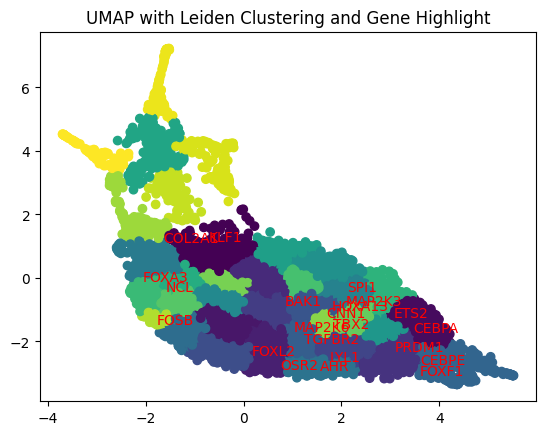

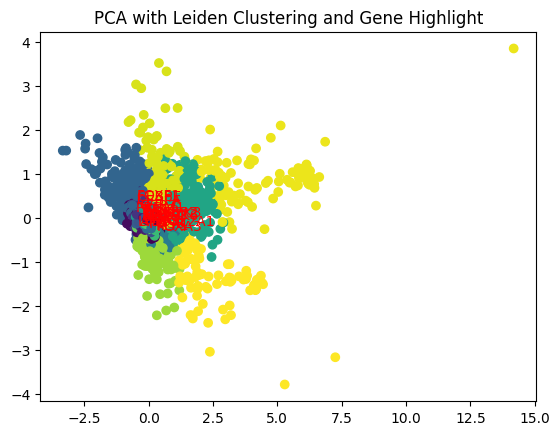

In [53]:

knn_graph=kneighbors_graph(umap_result,n_neighbors=15,include_self=False)
sources,targets=knn_graph.nonzero()
edges=list(zip(sources,targets))
g=ig.Graph(edges,directed=False)
partition=la.find_partition(g,la.RBConfigurationVertexPartition,resolution_parameter=1.0)

plt.scatter(umap_result[:,0],umap_result[:,1],c=partition.membership,cmap='viridis')
for gene in genes_of_interest:
    idx=np.where(df.columns==gene)[0][0]
    plt.annotate(gene,(umap_result[idx,0],umap_result[idx,1]),color='red')
plt.title('UMAP with Leiden Clustering and Gene Highlight')
plt.show()

pca_model=PCA(n_components=2)
pca_result=pca_model.fit_transform(df.values)

plt.scatter(pca_result[:,0],pca_result[:,1],c=partition.membership,cmap='viridis')
for gene in genes_of_interest:
    idx=np.where(df.columns==gene)[0][0]
    plt.annotate(gene,(pca_result[idx,0],pca_result[idx,1]),color='red')
plt.title('PCA with Leiden Clustering and Gene Highlight')
plt.show()
